In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from pylab import rcParams
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.pyplot import figure


rcParams['figure.figsize'] = 10, 6
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
df = pd.read_csv("data/model_training_data.csv").drop(["Unnamed: 0"], axis=1)
df.head()

,animeID,title_english,episodes,score,scored_by,rank,popularity,members,favorites,genre_Action,...,synopsis_embedded_296,synopsis_embedded_297,synopsis_embedded_298,synopsis_embedded_299,synopsis_embedded_300,premiered_Spring,premiered_Summer,premiered_Fall,premiered_Winter,premiered_Year
0,1,Cowboy Bebop,26.0,8.81,405664,26,39,795733,43460,1,...,-0.015616,0.003619,-0.010637,0.043498,-0.007210,1.0,0.0,0.0,0.0,1998
1,5,Cowboy Bebop: The Movie,1.0,8.41,120243,164,449,197791,776,1,...,0.013802,0.005209,-0.006860,0.036505,-0.017165,0.0,0.0,0.0,0.0,0
2,6,Trigun,26.0,8.30,212537,255,146,408548,10432,1,...,-0.004276,0.010292,-0.036921,0.017824,0.005914,1.0,0.0,0.0,0.0,1998
3,7,Witch Hunter Robin,26.0,7.33,32837,2371,1171,79397,537,1,...,-0.008391,0.026849,-0.003479,0.048176,-0.002020,0.0,1.0,0.0,0.0,2002
4,8,Beet the Vandel Buster,52.0,7.03,4894,3544,3704,11708,14,0,...,-0.009359,-0.016920,-0.021534,0.047166,-0.012552,0.0,0.0,1.0,0.0,2004


In [3]:
len(df)

2855

# PCA, plot in 2D

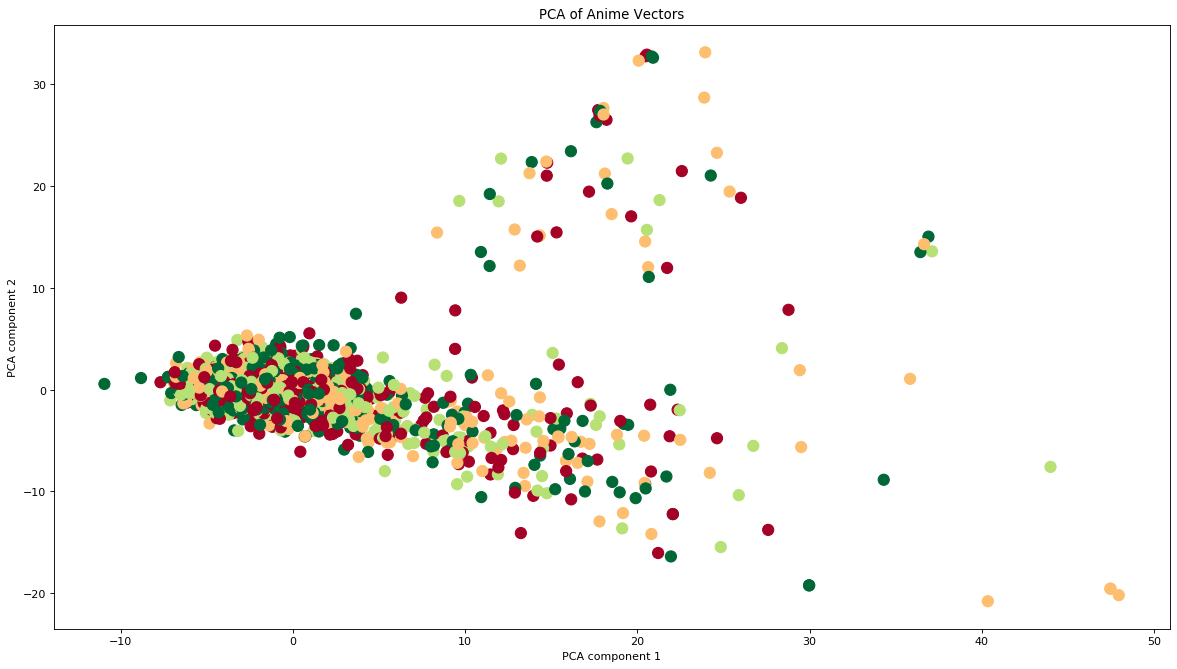

In [4]:
# make plot bigger
figure(num=None, figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')

# normalize all the data
feature_cols = df.columns.tolist()
feature_cols.remove("animeID") # remove label
feature_cols.remove("title_english")

features = df[feature_cols]

scaled_features = StandardScaler().fit_transform(features)

# PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(scaled_features)
principal_df = pd.DataFrame(data=principalComponents, columns = ['principal component 1', 'principal component 2'])


final_df = pd.concat([principal_df, df[['title_english']]], axis=1)


norm = plt.Normalize(1,4)
cmap = plt.cm.RdYlGn
c = np.random.randint(1,5,size=len(df))

final_arr = np.array(final_df)
plt.scatter(final_arr[:, 0], final_arr[:, 1], c=c, s=100, cmap=cmap, norm=norm)
plt.title("PCA of Anime Vectors")
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')

plt.show()

# DBSCAN

Estimated number of clusters: 9
Estimated number of noise points: 310


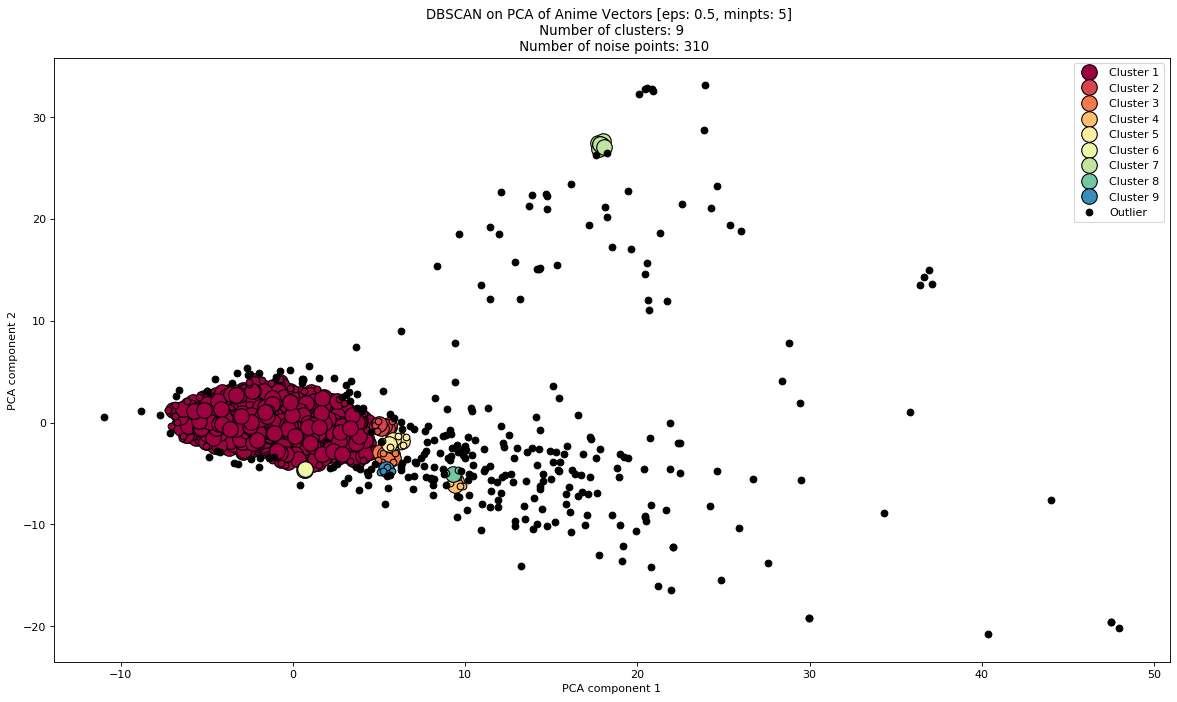

In [5]:
figure(num=None, figsize=(18, 10), dpi=80, facecolor='w', edgecolor='k')
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


# Compute DBSCAN
EPS=0.5
MIN_SAMPLES=5
db = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(final_arr[:, 0:2])
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_


# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    if k == -1:
        xy = final_arr[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = final_arr[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6, label="Outlier")
    else:
        xy = final_arr[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14, label="Cluster {}".format(k+1))

        xy = final_arr[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

plt.legend()
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.title('DBSCAN on PCA of Anime Vectors [eps: {}, minpts: {}] \n Number of clusters: {} \n Number of noise points: {}'.format(EPS, MIN_SAMPLES, n_clusters_, n_noise_))
plt.show()

In [6]:
# obtain top-k anime in each cluster
topk = 10

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    if k == -1:
        xy = final_arr[class_member_mask]
        all_anime_in_cluster = xy[:, 2]
        print ('In cluster: {} | top-k: {} | all_anime_in_cluster: {}'.format("Outlier", topk, all_anime_in_cluster[:topk]))
    else:
        xy = final_arr[class_member_mask]
        all_anime_in_cluster = xy[:, 2]
        print ('In cluster: {} | top-k: {} | all_anime_in_cluster: {}'.format(k+1, topk, all_anime_in_cluster[:topk])) 

In cluster: 1 | top-k: 10 | all_anime_in_cluster: ['Cowboy Bebop' 'Cowboy Bebop: The Movie' 'Trigun' 'Witch Hunter Robin'
 'Beet the Vandel Buster' 'Honey and Clover' 'Monster' 'Naruto'
 'The Prince of Tennis' 'Desert Punk']
In cluster: 2 | top-k: 10 | all_anime_in_cluster: ['One Piece: Clockwork Island Adventure' 'Steel Angel Kurumi Encore'
 'Starship Girl Yamamoto Yohko' 'Magical Girl Lyrical Nanoha StrikerS'
 'Super Bestial Machine God Dancougar'
 'Mobile Suit Gundam 0083: The Afterglow Of Zeon' 'A Great Super Shot Boy'
 'School Rumble 3rd Semester' 'Pokémon: Black & White'
 'Wanna Be the Strongest in the World']
In cluster: 3 | top-k: 10 | all_anime_in_cluster: ['Mobile Suit Gundam F91' 'Death Note: Relight' 'Master Hamsters'
 'Dinosaur King D-Kids Adventure: Pterosaur Legend' 'Star Cat Fullhouse'
 'Halo Legends' 'Ring of Gundam' 'Mix Master: King of Cards'
 'Pokémon Ranger: Guardian Signs'
 'Little Nemo: Adventures in Slumberland Pilot']
In cluster: 4 | top-k: 10 | all_anime_in_cl

# Feature Correlation Matrix

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
def correlation_heatmap(df):
    
    correlations = df.corr()
    fig, ax = plt.subplots(figsize=(15,15))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show()

# get standardized df for correlation #
feature_titles = df.drop(['animeID', 'title_english'], axis=1).columns.tolist()
corr_df = pd.DataFrame(data=scaled_features, columns=feature_titles)
drop_cols = [x for x in df.columns.tolist() if "synopsis" in x]
corr_df_no_synopsis = corr_df.drop(drop_cols, axis=1)
corr_df_no_synopsis.head()

,episodes,score,scored_by,rank,popularity,members,favorites,genre_Action,genre_Adventure,genre_Comedy,...,type_Music,type_ONA,type_OVA,type_Special,type_TV,premiered_Spring,premiered_Summer,premiered_Fall,premiered_Winter,premiered_Year
0,0.166730,2.059094,3.666161,-1.252698,-1.028523,4.233284,6.739129,1.242805,1.764606,1.108480,...,-0.062192,-0.176233,-0.353414,-0.256313,0.726892,2.028913,-0.378645,-0.507105,-0.384068,0.716489
1,-0.389673,1.567628,0.712461,-1.202267,-0.885544,0.592367,-0.134356,1.242805,-0.566699,-0.902136,...,-0.062192,-0.176233,-0.353414,-0.256313,-1.375719,-0.492875,-0.378645,-0.507105,-0.384068,-1.374612
2,0.166730,1.432475,1.667572,-1.169011,-0.991209,1.875683,1.420568,1.242805,1.764606,1.108480,...,-0.062192,-0.176233,-0.353414,-0.256313,0.726892,2.028913,-0.378645,-0.507105,-0.384068,0.716489
3,0.166730,0.240672,-0.192066,-0.395730,-0.633761,-0.128544,-0.172842,1.242805,-0.566699,-0.902136,...,-0.062192,-0.176233,-0.353414,-0.256313,0.726892,-0.492875,2.640996,-0.507105,-0.384068,0.720676
4,0.745389,-0.127927,-0.481236,0.032937,0.249572,-0.540708,-0.257062,-0.804632,1.764606,-0.902136,...,-0.062192,-0.176233,-0.353414,-0.256313,0.726892,-0.492875,-0.378645,1.971978,-0.384068,0.722769


In [17]:
df.columns.tolist()

['animeID',
 'title_english',
 'episodes',
 'score',
 'scored_by',
 'rank',
 'popularity',
 'members',
 'favorites',
 'genre_Action',
 'genre_Adventure',
 'genre_Comedy',
 'genre_Dementia',
 'genre_Drama',
 'genre_Ecchi',
 'genre_Fantasy',
 'genre_Game',
 'genre_Harem',
 'genre_Historical',
 'genre_Horror',
 'genre_Kids',
 'genre_Magic',
 'genre_Military',
 'genre_Music',
 'genre_Mystery',
 'genre_Psychological',
 'genre_Romance',
 'genre_Sci-Fi',
 'genre_Slice of Life',
 'genre_Sports',
 'studio_"Brains Base"',
 'studio_A-1 Pictures',
 'studio_AIC',
 'studio_Arms',
 'studio_Bones',
 'studio_Diomedea',
 'studio_Doga Kobo',
 'studio_Gainax',
 'studio_Gonzo',
 'studio_J.C.Staff',
 'studio_Kyoto Animation',
 'studio_MAPPA',
 'studio_Madhouse',
 'studio_Manglobe',
 'studio_Nippon Animation',
 'studio_OLM',
 'studio_P.A. Works',
 'studio_Production I.G',
 'studio_Production Reed',
 'studio_Satelight',
 'studio_Shaft',
 'studio_Shin-Ei Animation',
 'studio_Silver Link.',
 'studio_Studio Deen

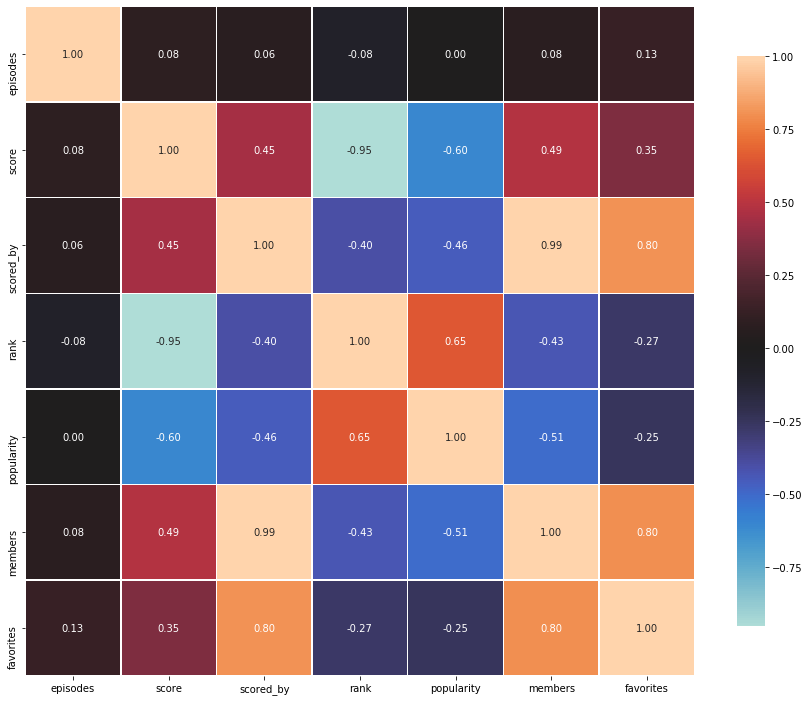

In [27]:
# stats #
anime_stat_titles = corr_df_no_synopsis.columns.tolist()[:7]
correlation_heatmap(corr_df_no_synopsis[anime_stat_titles])

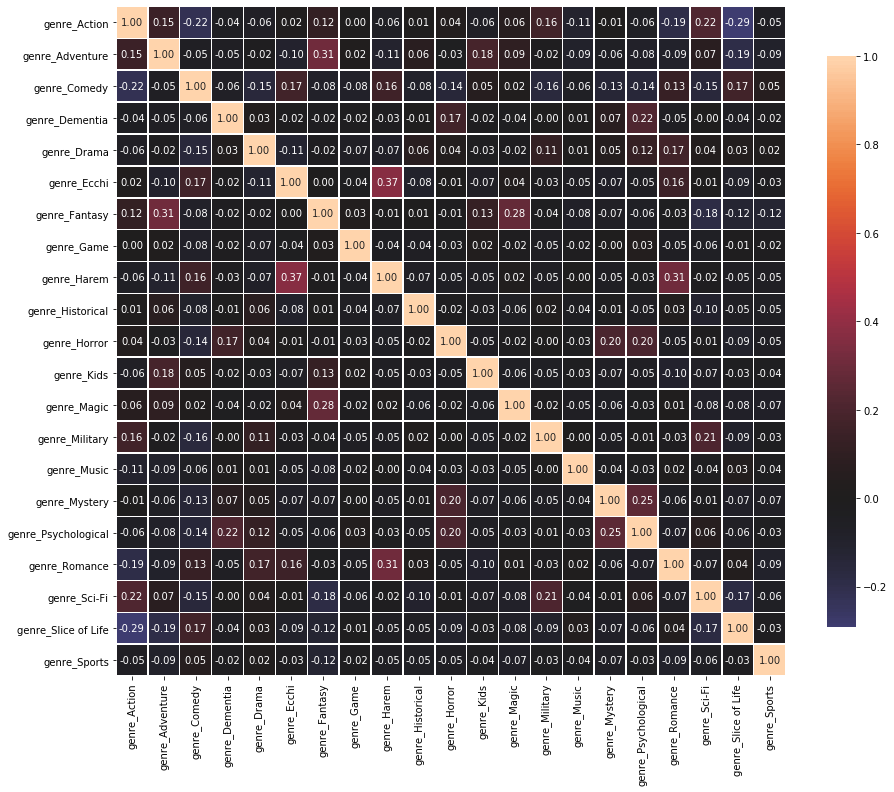

In [28]:
# genre #
anime_genre_titles = [x for x in corr_df_no_synopsis.columns.tolist() if "genre" in x]
correlation_heatmap(corr_df_no_synopsis[anime_genre_titles])

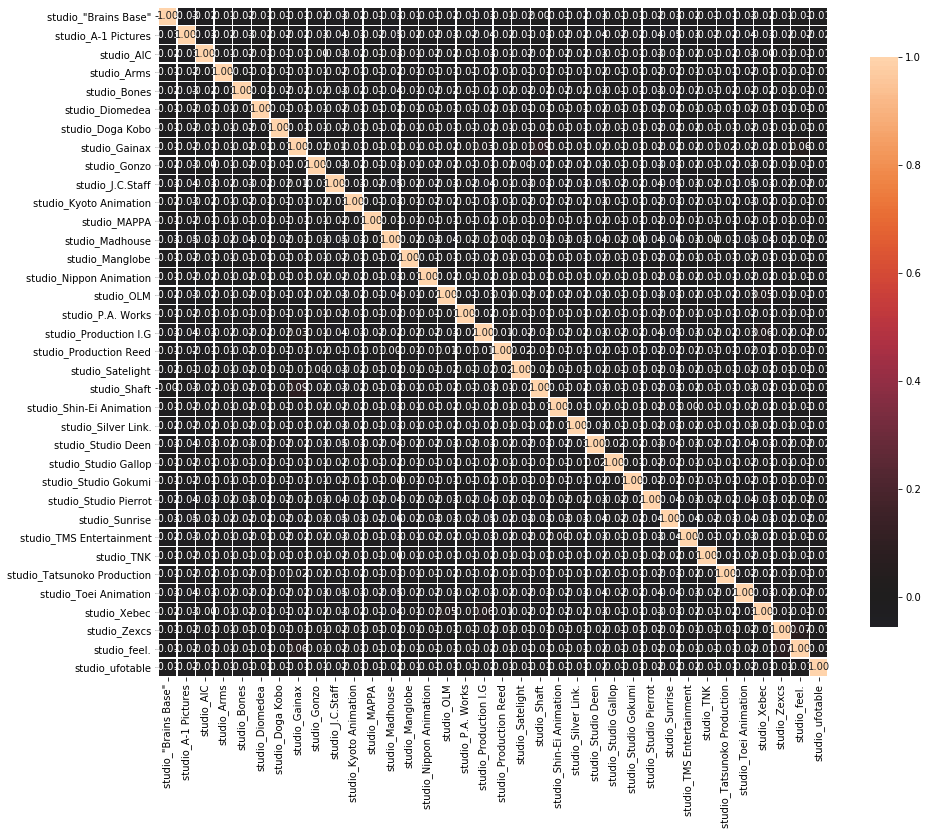

In [29]:
# studio #
anime_studio_titles = [x for x in corr_df_no_synopsis.columns.tolist() if "studio" in x]
correlation_heatmap(corr_df_no_synopsis[anime_studio_titles])

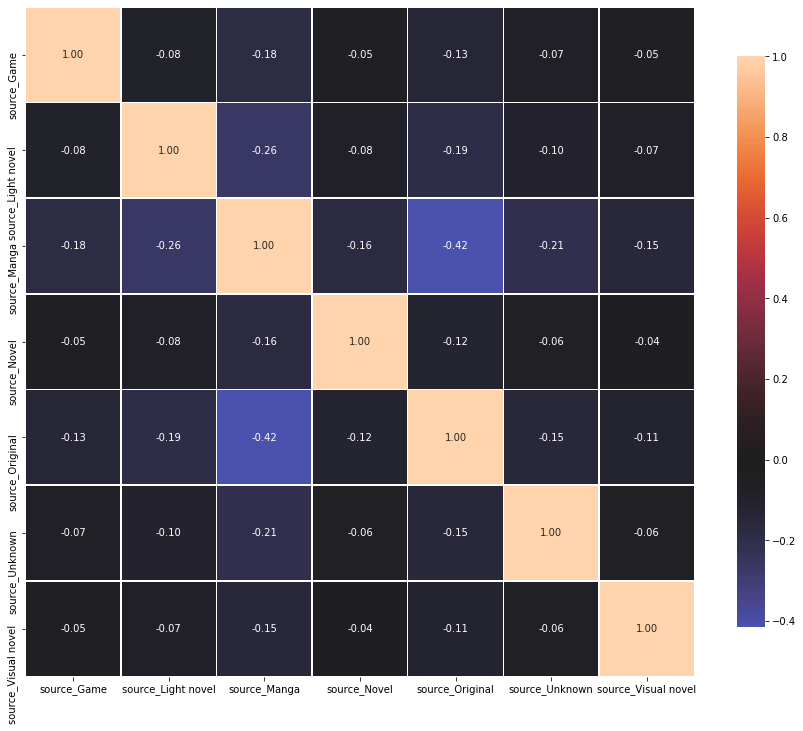

In [30]:
# source #
anime_source_titles = [x for x in corr_df_no_synopsis.columns.tolist() if "source" in x]
correlation_heatmap(corr_df_no_synopsis[anime_source_titles])

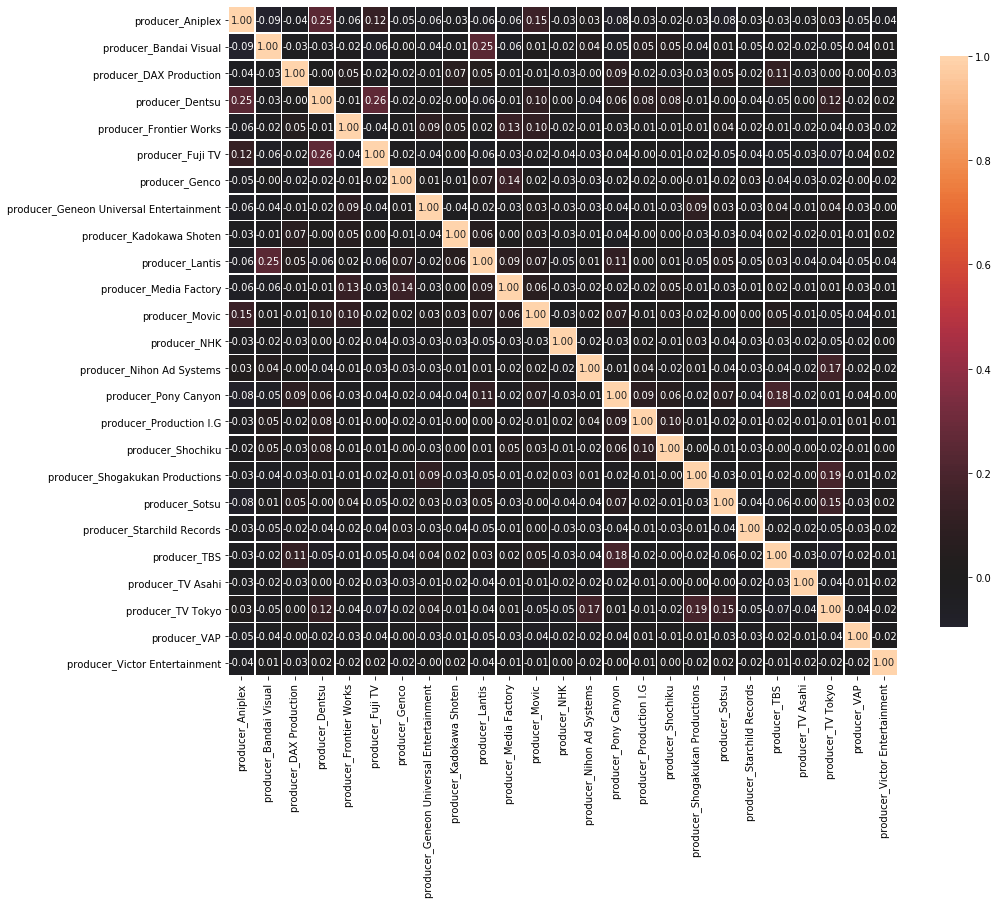

In [31]:
# producer #
anime_producer_titles = [x for x in corr_df_no_synopsis.columns.tolist() if "producer" in x]
correlation_heatmap(corr_df_no_synopsis[anime_producer_titles])

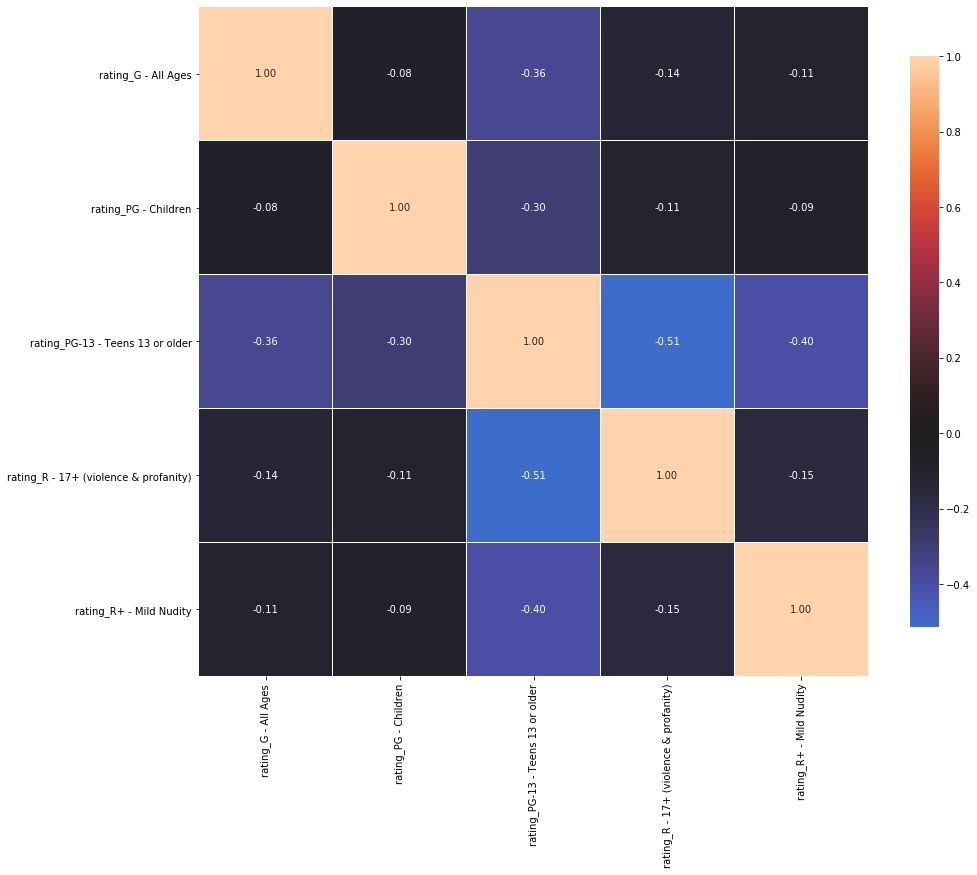

In [32]:
# rating #
anime_rating_titles = [x for x in corr_df_no_synopsis.columns.tolist() if "rating" in x]
correlation_heatmap(corr_df_no_synopsis[anime_rating_titles])

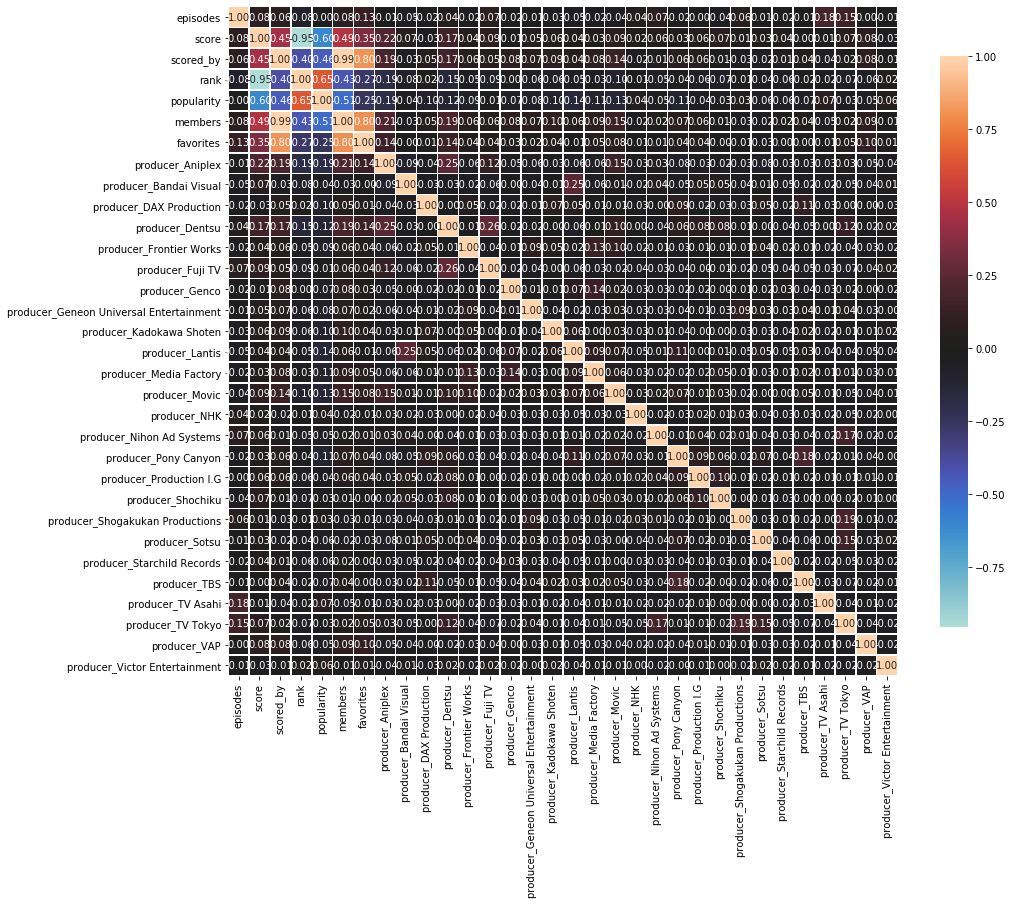

In [33]:
# stats vs producer #
stats_producer_titles = anime_stat_titles + anime_producer_titles
correlation_heatmap(corr_df_no_synopsis[stats_producer_titles])

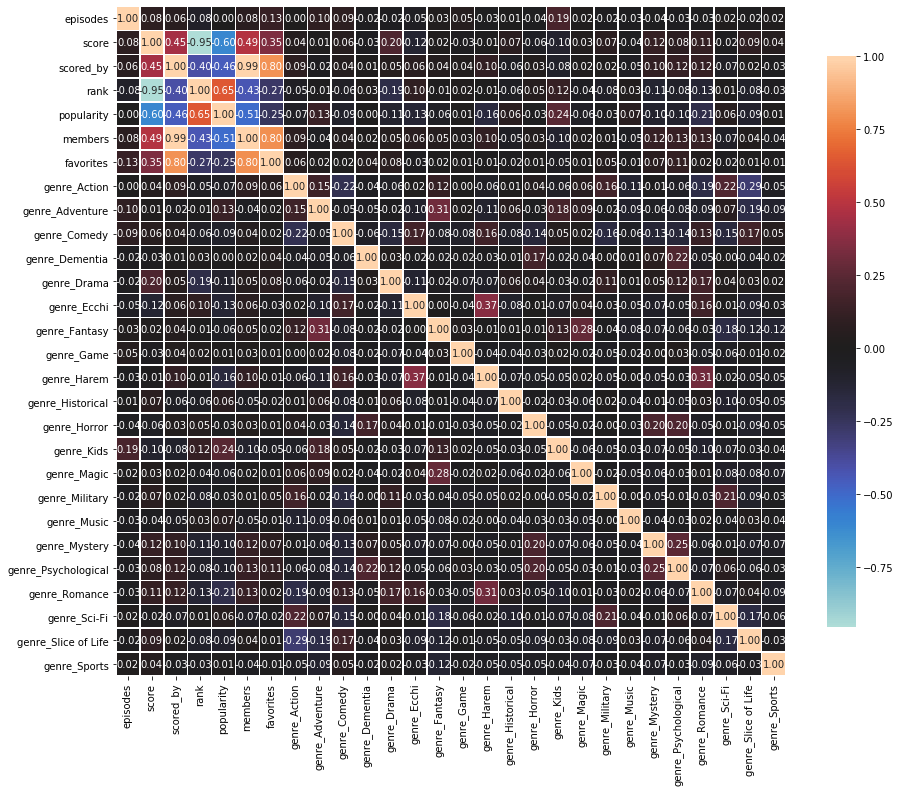

In [34]:
# stats vs genre #
stats_genre_titles = anime_stat_titles + anime_genre_titles
correlation_heatmap(corr_df_no_synopsis[stats_genre_titles])